# Mask R-CNN - Train on Open Images Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [7]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import skimage.io
import json

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Select GPU
os.environ["CUDA_VISIBLE_DEVICES"]="6"

## Configurations

In [2]:
# Open Images Dataset
from open_images import OpenImagesConfig, OpenImagesDataset
config = OpenImagesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                313
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Load Open Images dataset.

In [10]:
dataset_dir = "/data/xzz/OpenImage"
annotations_dir = os.path.join(dataset_dir, "challenge-2019-instance-segmentation-track-annotations")
subset = "train"
annotations_df_tra = pd.read_csv(os.path.join(annotations_dir, 
                                              "challenge-2019-{}-segmentation-masks.csv".format(subset)))
subset = "validation"
annotations_df_val = pd.read_csv(os.path.join(annotations_dir, 
                                              "challenge-2019-{}-segmentation-masks.csv".format(subset)))

In [46]:
import collections

annotations_hash_val = collections.defaultdict(list)
for row in annotations_df_val.to_dict('record'):
    annotations_hash_val[row['ImageID']].append(row)

annotations_hash_tra = collections.defaultdict(list)
for row in annotations_df_tra.to_dict('record'):
    annotations_hash_tra[row['ImageID']].append(row)

In [47]:
with open('/data/zhenghan/open_images/train.json', 'w') as f:
    json.dump(annotations_hash_tra, f, indent=4)
with open('/data/zhenghan/open_images/validation.json', 'w') as f:
    json.dump(annotations_hash_val, f, indent=4)

In [9]:
with open('/data/zhenghan/open_images/train.json', 'r') as f:
    annotations_hash = json.load(f)
annotations_hash["de247e6486ec058a"]
#annotations_df_val[annotations_df_val.ImageID=="0d87b8c4ea2f4c79"].to_dict('record')

KeyError: 'de247e6486ec058a'

In [14]:
type(annotations_hash)
#annotations_df_val[annotations_df_val.ImageID=='de247e6486ec058a']

dict

In [ ]:
image_dir = "/data/xzz/OpenImage/train/train_0"
#image_dir = "/data/xzz/OpenImage/validation"
file_names = next(os.walk(image_dir))[2]
for i in range(len(file_names)):
    file_name = file_names[i]
    open_image_id = os.path.splitext(file_name)[0]
    print(open_image_id)
    annotations = annotations_df_tra[annotations_df.ImageID==open_image_id].to_dict('record')
    # Skip the images with no mask annotations
    print(annotations)
    if not annotations:
        continue
    #for ann in annotations:
    #    ann["MaskPath"] = os.path.join(mask_dir, ann["MaskPath"])
    print(file_name)

In [ ]:
OPEN_IMAGES_DIR = "/data/xzz/OpenImage"

# Training dataset
dataset_train = OpenImagesDataset()
dataset_train.load_open_images(OPEN_IMAGES_DIR, "train")
dataset_train.prepare()
# print(dataset_train.image_info)

# Validation dataset
dataset_val = OpenImagesDataset()
dataset_val.load_open_images(OPEN_IMAGES_DIR, "validation")
dataset_val.prepare()

8ea6293e2650e41c.jpg


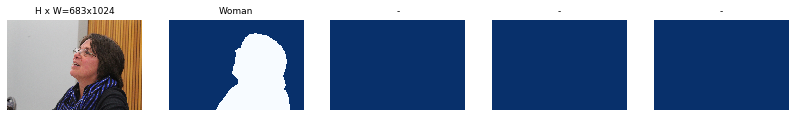

204fbc1bb05ba8a0.jpg


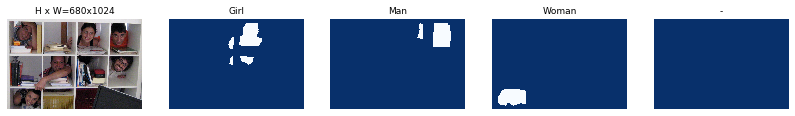

2113342c91d43cf8.jpg


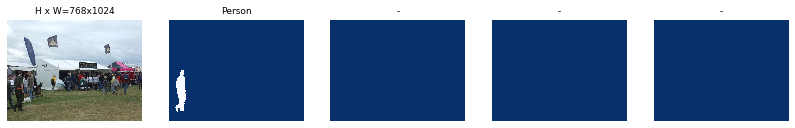

e08dfc2ce2971830.jpg


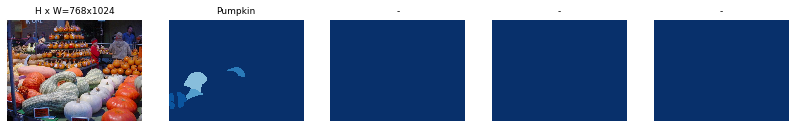

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print("{}.jpg".format(dataset_train.image_info[image_id]["id"]))
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads')


Starting at epoch 1. LR=0.001

Checkpoint Path: /shenlab/lab_stor/zhenghan/code/open-images-challenge/Mask_RCNN/logs/open_images20190830T1512/mask_rcnn_open_images_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)

/shenlab/lab_stor/zhenghan/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/shenlab/lab_stor/zhenghan/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/shenlab/lab_stor/zhenghan/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/shenlab/lab_stor/zhenghan/miniconda3/lib/python3.7/site-packages/keras/engine/

Epoch 2/20
1000/1000 [==============================] - 644s 644ms/step - loss: 0.3486 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0733 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1287 - val_loss: 2.5519 - val_rpn_class_loss: 0.0043 - val_rpn_bbox_loss: 0.4260 - val_mrcnn_class_loss: 0.7153 - val_mrcnn_bbox_loss: 0.7257 - val_mrcnn_mask_loss: 0.6806
Epoch 3/20
 227/1000 [=====>........................] - ETA: 7:07 - loss: 0.7180 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1013 - mrcnn_class_loss: 0.1312 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.3305

In [15]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /shenlab/lab_stor/zhenghan/code/open-images-challenge/Mask_RCNN/logs/open_images20190815T2105/mask_rcnn_open_images_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (

/shenlab/lab_stor/zhenghan/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/shenlab/lab_stor/zhenghan/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/shenlab/lab_stor/zhenghan/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/shenlab/lab_stor/zhenghan/miniconda3/lib/python3.7/site-packages/keras/engine/

Epoch 2/2
1000/1000 [==============================] - 1039s 1s/step - loss: 2.8979 - rpn_class_loss: 0.1365 - rpn_bbox_loss: 2.0832 - mrcnn_class_loss: 0.0836 - mrcnn_bbox_loss: 0.2034 - mrcnn_mask_loss: 0.3912 - val_loss: 0.8907 - val_rpn_class_loss: 0.0170 - val_rpn_bbox_loss: 0.2851 - val_mrcnn_class_loss: 0.1052 - val_mrcnn_bbox_loss: 0.1883 - val_mrcnn_mask_loss: 0.2950
Epoch 2/2


In [16]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [17]:
class InferenceConfig(OpenImagesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

W0815 21:47:32.476437 140450727065408 deprecation_wrapper.py:119] From /shenlab/lab_stor/zhenghan/code/open-images-challenge/Mask_RCNN/mrcnn/model.py:720: The name tf.sets.set_intersection is deprecated. Please use tf.sets.intersection instead.

W0815 21:47:32.586686 140450727065408 deprecation.py:323] From /shenlab/lab_stor/zhenghan/code/open-images-challenge/Mask_RCNN/mrcnn/model.py:772: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Loading weights from  /shenlab/lab_stor/zhenghan/code/open-images-challenge/Mask_RCNN/logs/open_images20190815T2105/mask_rcnn_open_images_0002.h5
Re-starting from epoch 2


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (313,)                min:    0.00000  max: 1596.00000  float64
gt_class_id              shape: (4,)                  min:  265.00000  max:  287.00000  int32
gt_bbox                  shape: (4, 4)                min:    0.00000  max: 1600.00000  int32
gt_mask                  shape: (1406, 1600, 4)       min:    0.00000  max:    1.00000  bool
<class 'numpy.int32'>


ValueError: operands could not be broadcast together with shapes (1406,1600) (1024,1024) (1024,1024) 

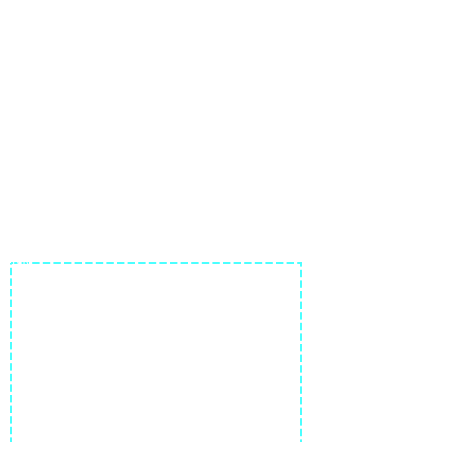

In [27]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 313)              min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


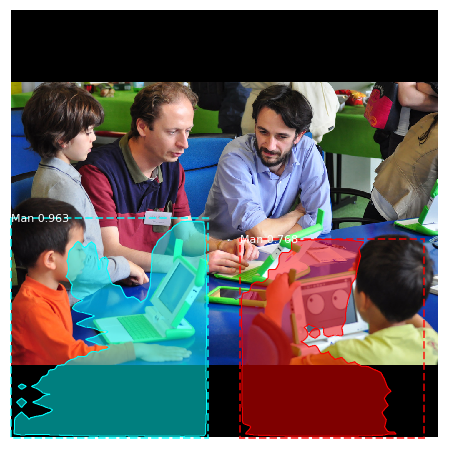

In [28]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [31]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0
